In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import eigsh
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as assembly
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 3: Rectangular Guide
# 3-noded Linear Triangular Elements, $P_1$

In [2]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Neumann', 'value': 0.0, 'name': 'Ez_0'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Create mesh from file geometry
mesh_data = ps.create_rectangular_guide(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1E-3, view_mesh=False)

Malha salva em pre_processing/mesh/rectangular_guide_domain_Triangle1.msh
Model rectangular_guide (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 3836 nodes in total
Info     : 7430 2-D elements in total


## Figure 1: Rectangular Guide meshed domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p31_rectangular_guide\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


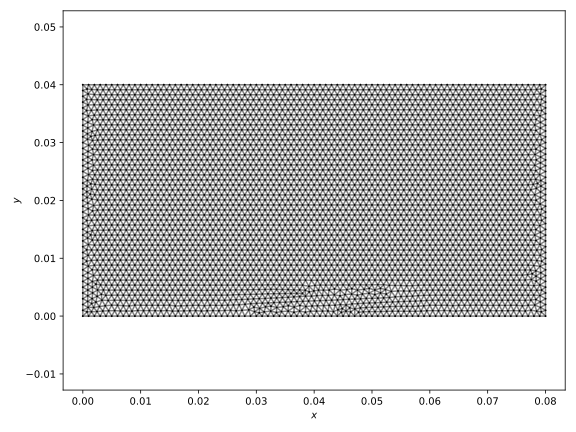

In [3]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## FEM Solution

In [4]:
Sgr, fgr, Mgr, Pgr, Qgr = assembly.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (3836, 3836)


## Eigenvalue Problem

In [5]:
# Resolver o problema de autovalor generalizado
# k Número de autovalores/autovetores desejados
eigenvalues, eigenvectors = eigsh(Sgr, k=6, M=Mgr, which='SM')

# Definir um limiar para eliminar erros de truncamento
threshold = 1e-8
positive_indices = np.where(eigenvalues > threshold)[0]

# Filtrar autovalores positivos e ordenar
sp_eigenvalues = eigenvalues[positive_indices]
sp_eigenvectors = eigenvectors[:, positive_indices]

# Ordenar os autovalores positivos e ajustar os autovetores na mesma ordem
s_indices = np.argsort(sp_eigenvalues)
sp_eigenvalues = sp_eigenvalues[s_indices]
sp_eigenvectors = sp_eigenvectors[:, s_indices]

print("Eigenvector shape:", eigenvectors.shape)
graph.matrix2table(sp_eigenvalues, title='Menores autovalores positivos')

Eigenvector shape: (3836, 6)


,1
1,1.542e+03
2,6.171e+03
3,6.171e+03
4,7.714e+03
5,1.235e+04


# Modos analíticos

In [6]:
te_modes = ps.waveguide_modes(m_max=5, n_max=5, mode_type='TE')


Cinco menores autovalores analíticos dos modos TE:
TE_10: kc2 = 1542.126 rad2/m2
TE_01: kc2 = 6168.503 rad2/m2
TE_20: kc2 = 6168.503 rad2/m2
TE_11: kc2 = 7710.628 rad2/m2
TE_21: kc2 = 12337.006 rad2/m2


# `calculate_error()`

In [7]:
ps.calculate_error(te_modes, sp_eigenvalues)

Modo TE_10: Erro percentual = 0.0096
Modo TE_01: Erro percentual = 0.0384
Modo TE_20: Erro percentual = 0.0387
Modo TE_11: Erro percentual = 0.0487
Modo TE_21: Erro percentual = 0.0772


# `get_modes_pattern()`

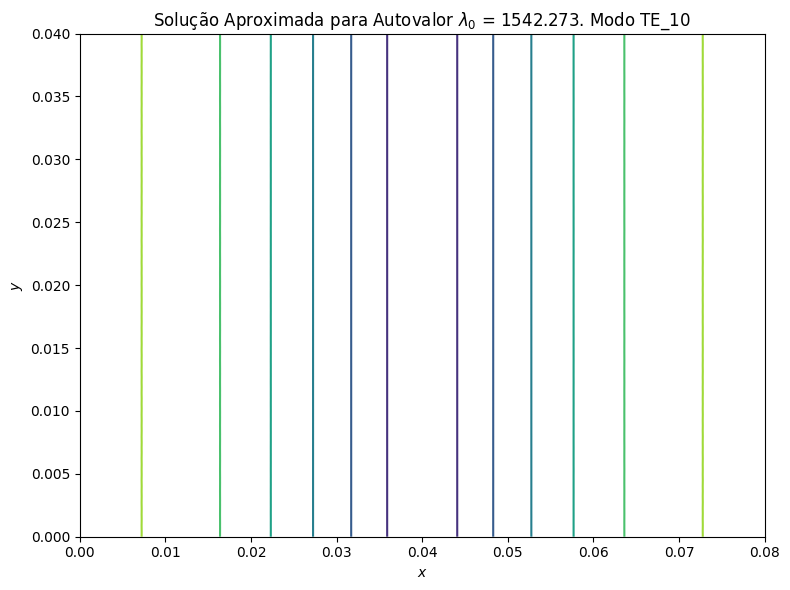

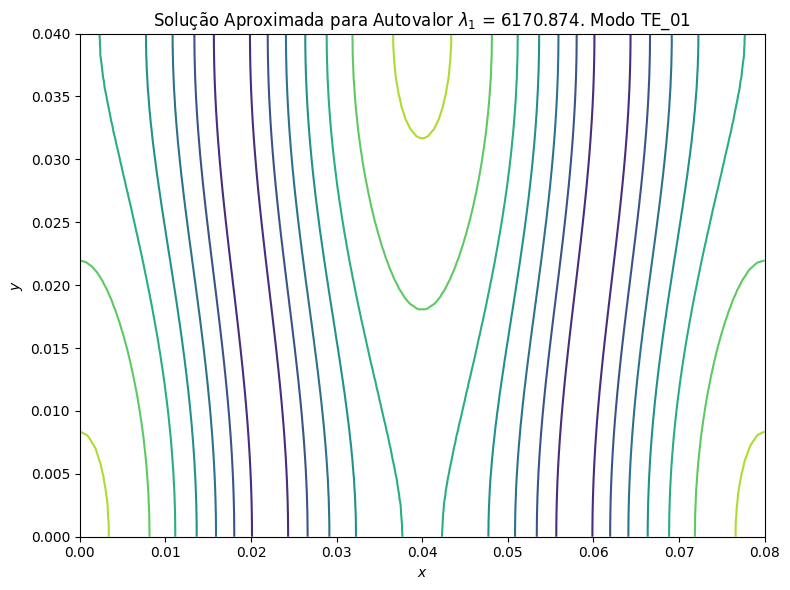

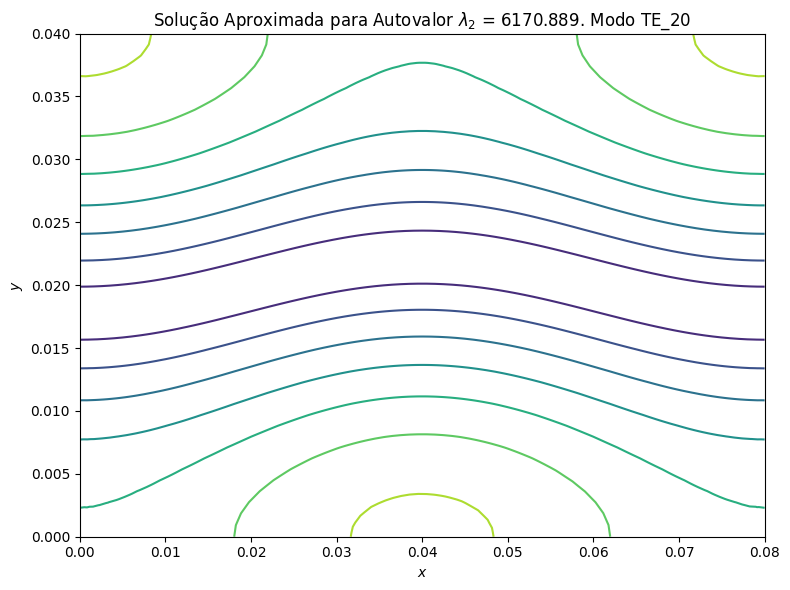

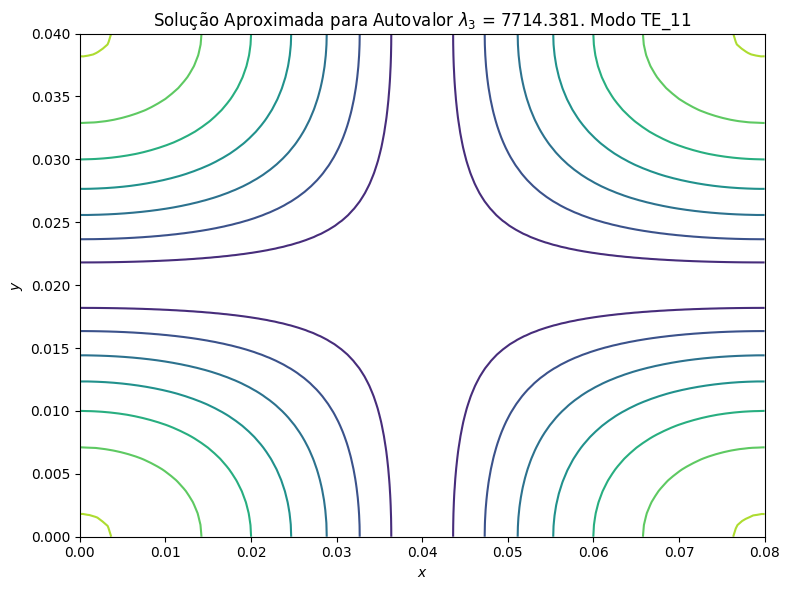

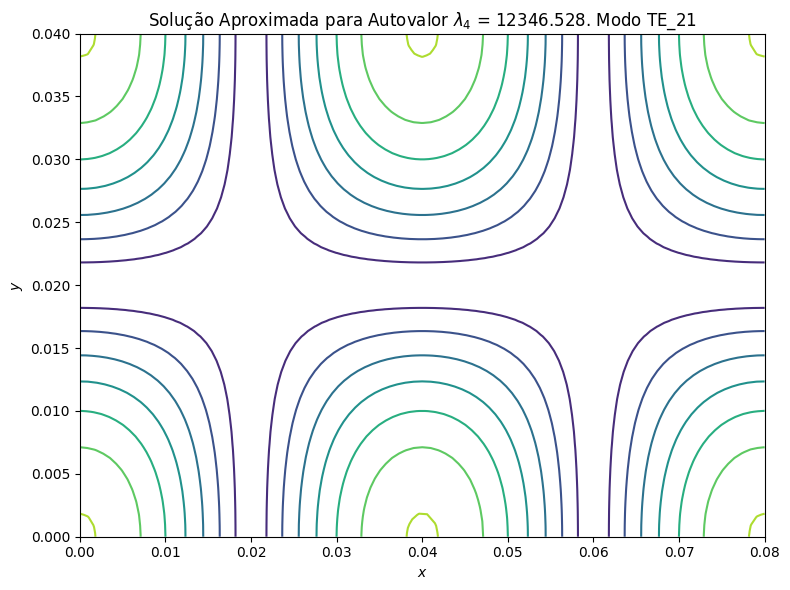

In [8]:
ps.get_modes_pattern(mesh_data, sp_eigenvalues, sp_eigenvectors, te_modes)

# `plot_dispersive_curve()`

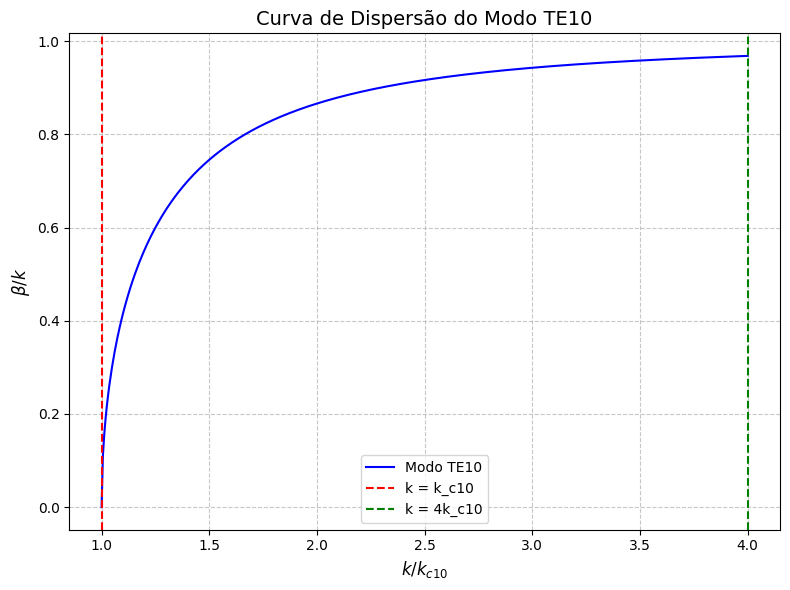

In [9]:
ps.plot_dispersive_curve(sp_eigenvalues)

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.